In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Statistical Analysis
# Statistical Tests, Plots, and Visualizations
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram


# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

from warnings import filterwarnings 
filterwarnings('ignore')
rng = np.random.RandomState(42)

df = pd.read_csv('./data/Energy Consumption Dataset.csv')

o P-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  


o P-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [2]:
df.head(8)

DATE  Gas Consumption (tons)  Electricity Consumption (MWh)  \
0  1/1/1990                    18.0                          725.1   
1  1/2/1990                    15.8                          706.7   
2  1/3/1990                    17.3                          624.5   
3  1/4/1990                    18.9                          574.7   
4  1/5/1990                    22.0                          553.2   
5  1/6/1990                    23.4                          580.9   
6  1/7/1990                    24.6                          626.2   
7  1/8/1990                    24.8                          632.5   

   Water Consumption (tons)  
0                     548.8  
1                     640.7  
2                     511.1  
3                     515.3  
4                     488.4  
5                     503.2  
6                     448.3  
7                     411.7

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [17]:
df.describe().T

count        mean         std    min    25%  \
Gas Consumption (tons)         397.0   23.785139    4.903452   11.6   20.2   
Electricity Consumption (MWh)  397.0  888.472544  153.877594  553.2  771.1   
Water Consumption (tons)       397.0  484.953652  133.908863   44.4  384.4   

                                 50%     75%     max  
Gas Consumption (tons)          23.5    27.9    46.0  
Electricity Consumption (MWh)  897.8  1005.2  1294.0  
Water Consumption (tons)       487.4   580.2   811.0

we can immediately see outlier in the water consumption data

In [5]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")

display(df.dtypes)

df.set_index("DATE", inplace=True)

DATE                             datetime64[ns]
Gas Consumption (tons)                  float64
Electricity Consumption (MWh)           float64
Water Consumption (tons)                float64
dtype: object

> I set the Date column as a datetime dtype and made it my index 

In [6]:
print(f'the dates are from {df.index.min()} to {df.index.max()}')
print(f'{df.index[0]}, {df.index[1]}')

the dates are from 1990-01-01 00:00:00 to 2023-01-01 00:00:00
1990-01-01 00:00:00, 1990-02-01 00:00:00


> The range of dates and we can see what each date represents

---

## Univariate Analysis

In [7]:
# sns.displot(x='Gas Consumption (tons)', kde=True, height=8, data=df)
# plt.title('Distribution of Gas Consumption (tons)')
# plt.show()

In [8]:
# sns.displot(x='Electricity Consumption (MWh)', kde=True, height=8, data=df, color = 'black')
# plt.title('Distribution of Gas Consumption (tons)')
# plt.show()

In [9]:
# sns.displot(x='Gas Consumption (tons)', kde=True, height=8, data=df, color = 'orange')
# plt.title('Water Consumption (tons)')
# plt.show()

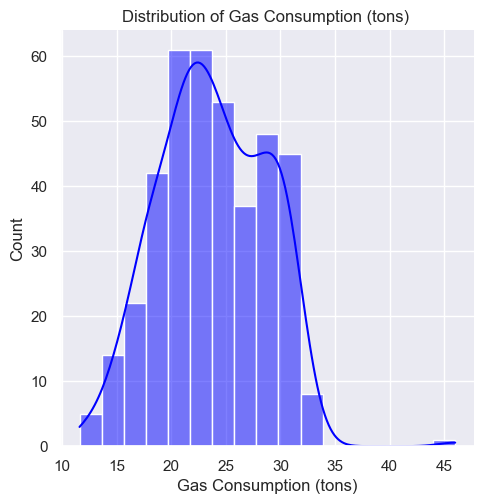

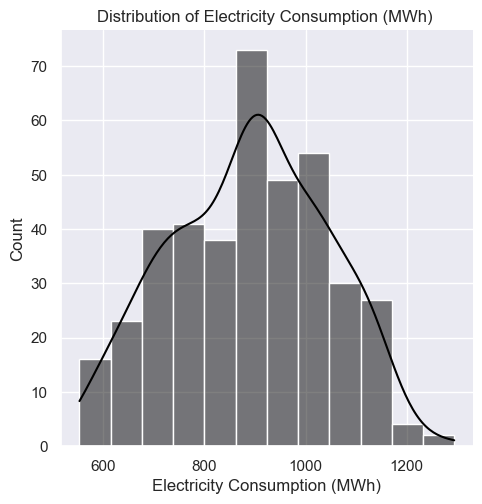

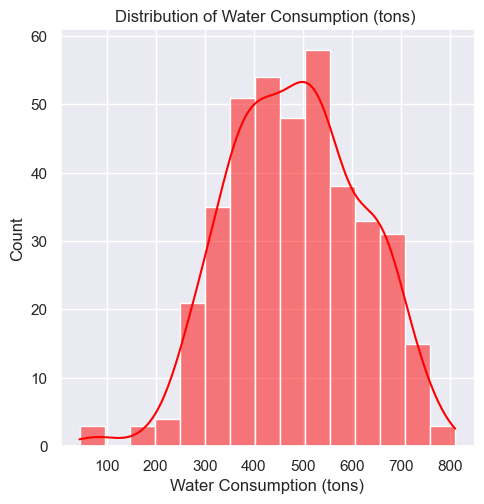

In [18]:
x_values = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
colors = ['blue', 'black', 'red']

for x, color in zip(x_values, colors):
    sns.displot(x=x, kde=True, height=5, data=df, color=color)
    plt.title(f"Distribution of {x} ")
    plt.show()

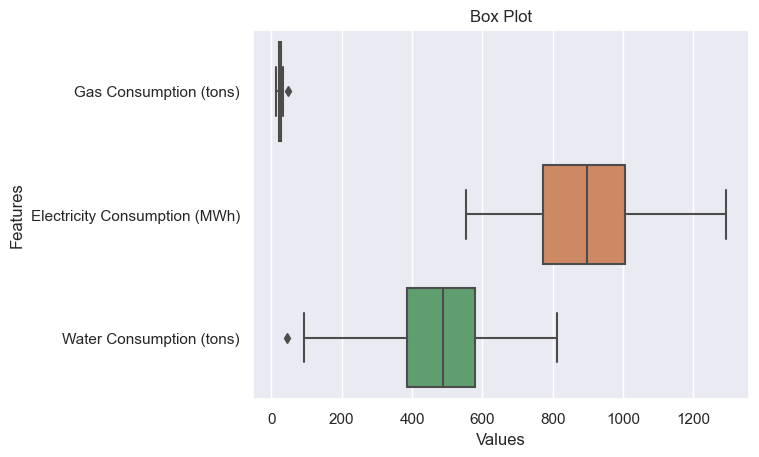

In [16]:
sns.boxplot(data=df , orient= 'h')

# Set labels and title
plt.xlabel("Values")
plt.ylabel("Features")
plt.title("Box Plot")

# Show the plot
plt.show()



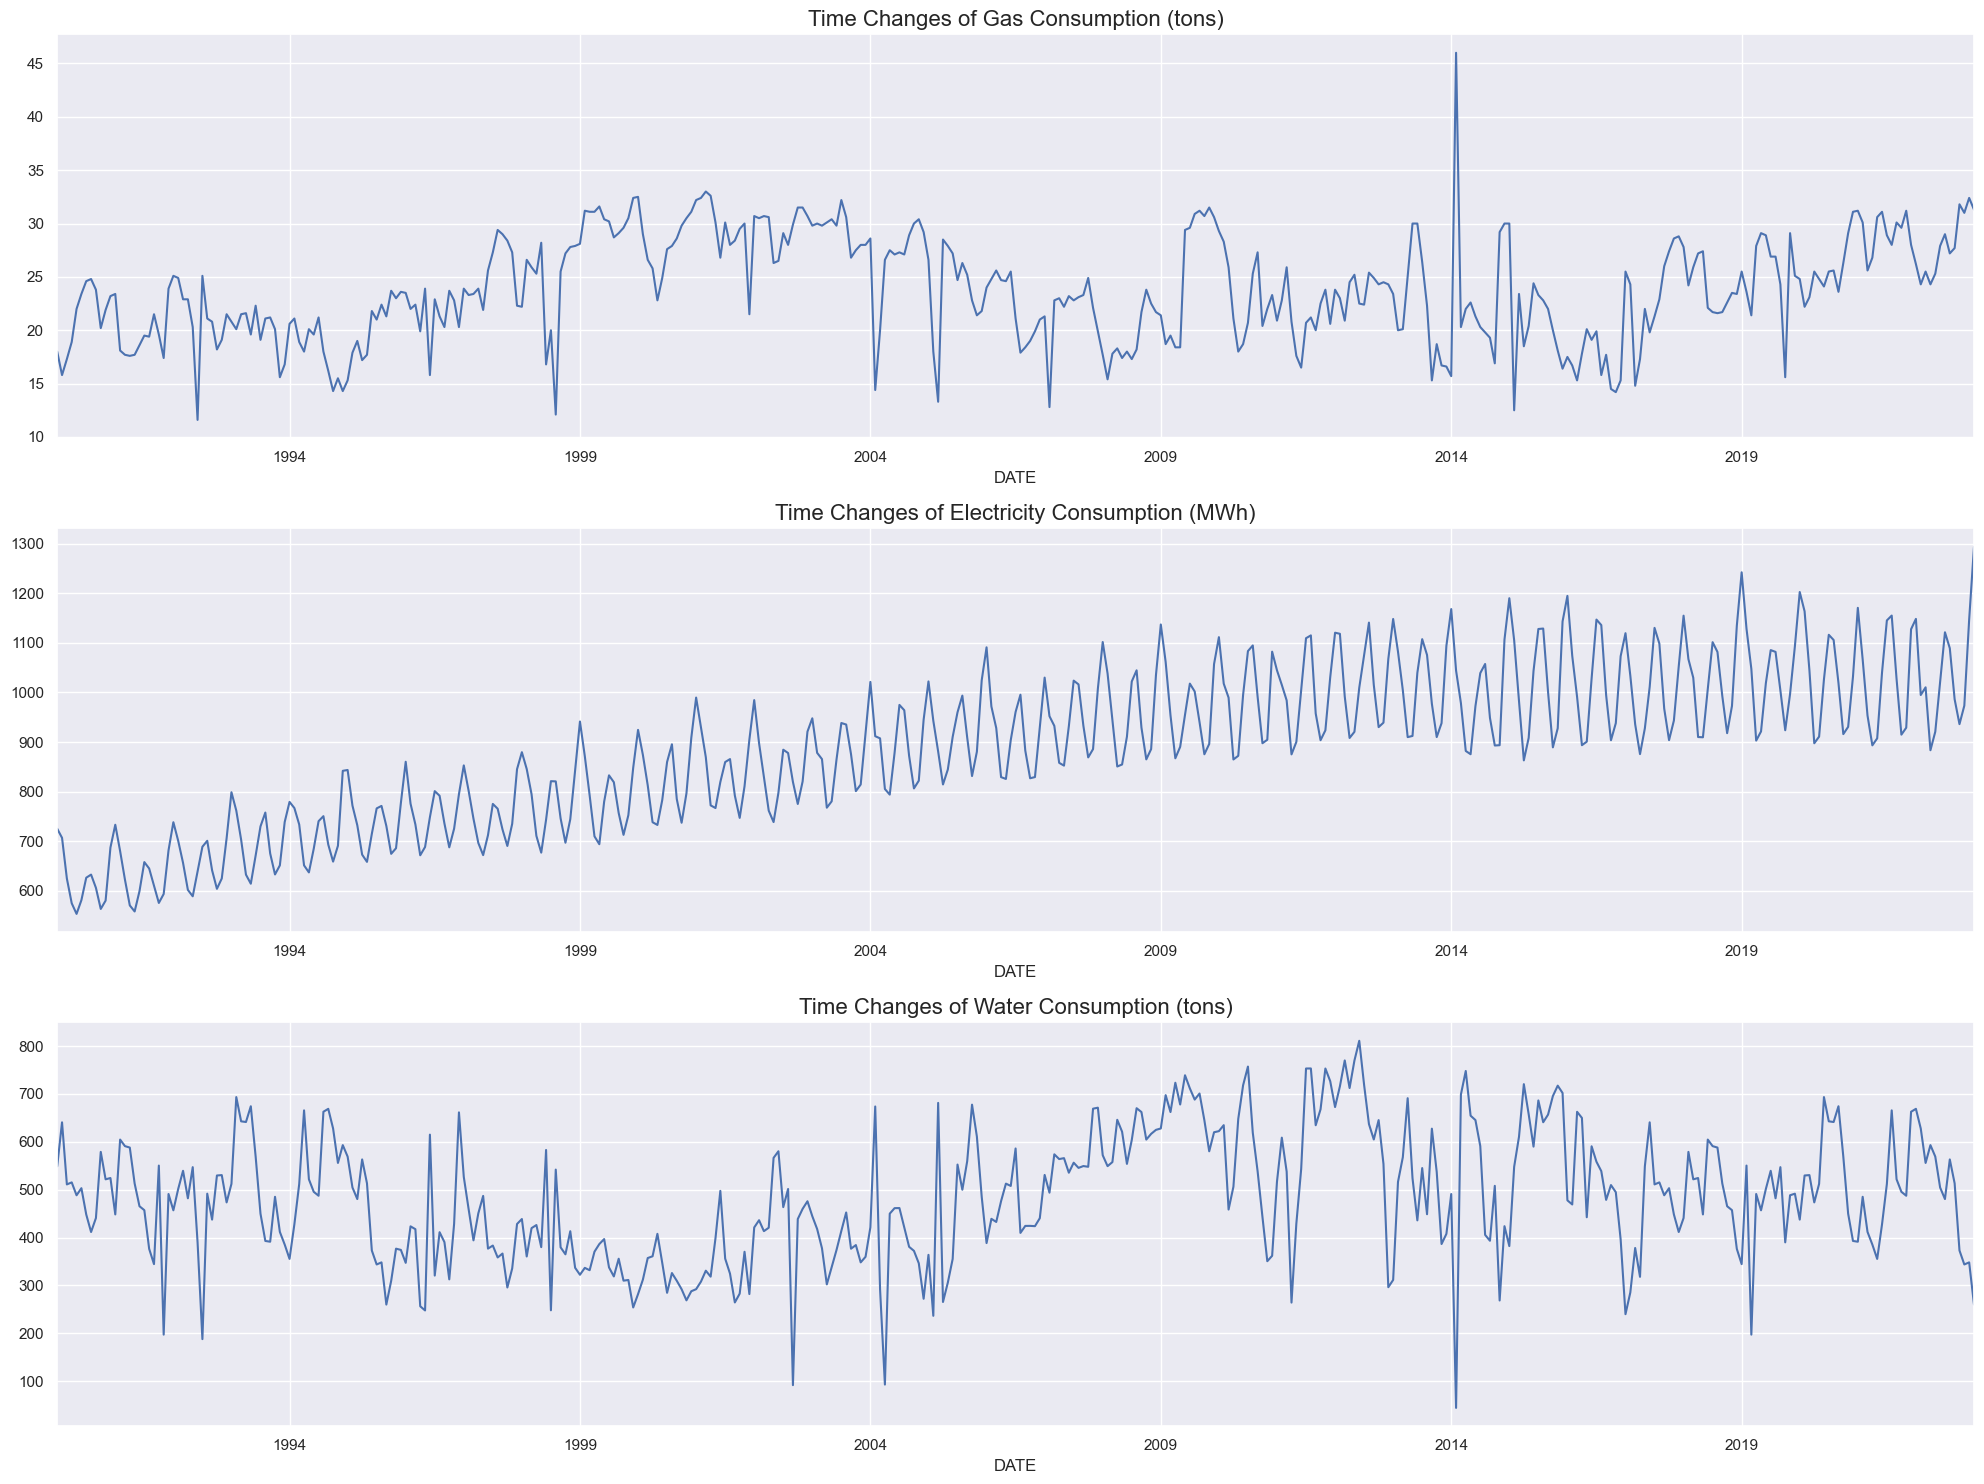

In [19]:
continuous = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
fig = plt.figure(tight_layout=True, figsize=(20, 15))
for i, column in enumerate(continuous):
    ax = fig.add_subplot(len(continuous), 1, i + 1)
    df[column].plot(ax=ax)
    ax.set_title("Time Changes of " + column, fontsize=16)
plt.show()

## Time Series Decomposition

Before we do anything we need to perform a few test to check the dataset, that includes
<!-- 
- Autocorrelation Test
- Stationarity Test
- Seasonality Test
- Unit Root Test
- Granger Causality Test
- Residual Analysis -->
- Test for Trends
- Test for Stationarity 
- Residual Analysis
- Outlier Analysis 

First lets start with the most basic test which is test for stationarity, many models such as ARIMA requires the data to be stationary to carry out forecasting, hence we need to check the each feature for stationarity, if it happens to not stationary we need to change that later on

Lets use the Dicky Fuller Test to evaluate

In [69]:
adftest = adfuller(df['Gas Consumption (tons)'])
signifcance_level = 0.05
print('Number of observations:', adftest[3])
print()
print(signifcance_level)
print('p-value', adftest[1])



print()
for key, value in adftest[4].items():
    # print("Significance Level:", key)
    print(f"Critical Value at {key}:", value)
    
print()    

print('Test Statistic Value:', adftest[0])


print()
if adftest[1] < signifcance_level:
    print('Reject Null Hypothesis')
    print('The data is Stationary')
else:
    print('Accept Null Hypothesis')
    print('The data is Non-Stationary')

Number of observations: 390

0.05
p-value 0.01081065170706051

Critical Value at 1%: -3.4472291365835566
Critical Value at 5%: -2.8689795375849223
Critical Value at 10%: -2.5707330834976987

Test Statistic Value: -3.4043743333182728

Reject Null Hypothesis
The data is Stationary


In [76]:
def evaluate_stationarity(data, columns, significance_level=0.05):
    for column in columns:
        adftest = adfuller(data[column])
        
        print("Column:", column)
        print("Number of observations:", adftest[3])
        print()
        print("Significance Level:", significance_level)
        print("p-value:", adftest[1])
 
            
        print()
        
        for key, value in adftest[4].items():
            print(f"Critical Value at {key}:", value)
    
        print('Test Statistic Value:', adftest[0])
        print()
        if adftest[1] < significance_level:
            print('Since p-value < significance level we reject the Null Hypothesis')
            print('The data is Stationary')
        else:
            print('Since p-value > significance level we Accept the Null Hypothesis')
            print('The data is Non-Stationary')

        print('-' * 50)
        print()

# Usage example
data = ...  # Your dataset
columns =  ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']  # Specify the columns to evaluate

evaluate_stationarity(df, columns)


Column: Gas Consumption (tons)
Number of observations: 390

Significance Level: 0.05
p-value: 0.01081065170706051

Critical Value at 1%: -3.4472291365835566
Critical Value at 5%: -2.8689795375849223
Critical Value at 10%: -2.5707330834976987
Test Statistic Value: -3.4043743333182728

Since p-value < significance level we reject the Null Hypothesis
The data is Stationary
--------------------------------------------------

Column: Electricity Consumption (MWh)
Number of observations: 381

Significance Level: 0.05
p-value: 0.18621802300336632

Critical Value at 1%: -3.4476305904172904
Critical Value at 5%: -2.869155980820355
Critical Value at 10%: -2.570827146203181
Test Statistic Value: -2.256980549592542

Since p-value > significance level we Accept the Null Hypothesis
The data is Non-Stationary
--------------------------------------------------

Column: Water Consumption (tons)
Number of observations: 392

Significance Level: 0.05
p-value: 8.984549388336973e-05

Critical Value at 1%: -

# References 

---

# Carbonara Recipe

## Ingredients
- 8 ounces spaghetti
- 4 slices bacon, chopped
- 2 cloves garlic, minced
- 2 large eggs
- 1/2 cup grated Parmesan cheese
- 1/4 cup heavy cream
- Salt and pepper, to taste
- Chopped fresh parsley, for garnish

## Instructions
1. Cook the spaghetti according to package instructions until al dente. Drain and set aside.
2. In a large skillet, cook the chopped bacon over medium heat until crispy. Remove the bacon from the skillet and set aside.
3. In the same skillet, add the minced garlic and cook for about 1 minute, until fragrant.
4. In a medium bowl, whisk together the eggs, grated Parmesan cheese, and heavy cream. Season with salt and pepper.
5. Pour the egg mixture into the skillet with the garlic and stir quickly to combine. Cook for about 1 minute, stirring constantly, until the sauce thickens slightly.
6. Add the cooked spaghetti to the skillet and toss until the pasta is coated evenly with the sauce.
7. Remove the skillet from heat and add the crispy bacon. Toss again to combine.
8. Garnish with chopped fresh parsley.
9. Serve the Carbonara immediately while it's still warm.

Enjoy your delicious Carbonara!